# Notebook 01: Data Collection and Exploration

In [1]:
# pip install psycopg2

In [2]:
import pandas as pd
import json
import psycopg2
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

True

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


### Style Setting

In [4]:
# Set the global aesthetic parameters
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14

# Define a custom color palette (Professional & Accessible)
# Blue for neutral, Orange for attention, Red for churn/risk
brand_colors = ["#2A52BE", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD"]
sns.set_palette(sns.color_palette(brand_colors))

# Apply consistent grid and border styles
sns.set_style("whitegrid", {
    "axes.edgecolor": "#D5D8DC",
    "grid.color": "#F2F3F4",
    "xtick.bottom": True,
    "ytick.left": True
})

print("Global visualization style set: Modern Corporate.")

Global visualization style set: Modern Corporate.


### Quering the Data and Storing it in a DataFrame

In [5]:
def load_and_process_data():
    # 1. Connection
    conn = psycopg2.connect(
        host=os.getenv('DB_HOST'),
        database=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        port=os.getenv('DB_PORT')
    )
    
    query = "SELECT * FROM call_logs;"
    df = pd.read_sql_query(query, conn)
    conn.close()

    # 2. Extract Features from Unstructured JSONB
    def process_transcript(row):
        transcript = json.loads(row['transcript_json']) if isinstance(row['transcript_json'], str) else row['transcript_json']
        
        # Combine text for NLP modeling
        full_text = " ".join([turn['text'] for turn in transcript])
        
        # Calculate Talk-to-Listen Ratio (Agent vs Customer word counts)
        agent_words = sum(len(t['text'].split()) for t in transcript if t['speaker'] == 'Agent')
        customer_words = sum(len(t['text'].split()) for t in transcript if t['speaker'] == 'Customer')
        
        # Avoid division by zero
        ratio = agent_words / customer_words if customer_words > 0 else 0
        
        return pd.Series({
            'clean_text': full_text,
            'agent_word_count': agent_words,
            'customer_word_count': customer_words,
            'talk_ratio': round(ratio, 2),
            'turns_count': len(transcript)
        })

    # Apply the processing
    features_df = df.apply(process_transcript, axis=1)
    df = pd.concat([df, features_df], axis=1)
    
    return df

In [6]:
pd.set_option('display.max_columns', None)

df = load_and_process_data()
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (1000, 24)


### The Transformation Script

In [7]:
# Feature set
def build_feature_set(df):
    # Handle Duplicates and Drop Redundant
    # Using a list to ensure we only get unique columns
    cols_to_keep = [
        'agent_id', 'timestamp', 'duration_sec', 'csat_score', 
        'issue_category', 'customer_persona', 'clean_text', 
        'talk_ratio', 'turns_count', 'resolved', 'escalated', 'churned'
    ]
    
    # Select first occurrence of columns to handle the duplicates in your current df
    new_df = df.loc[:, ~df.columns.duplicated()].copy()
    new_df = new_df[cols_to_keep]

    # Temporal Feature Engineering (JD Requirement: Advanced Processing)
    new_df['timestamp'] = pd.to_datetime(new_df['timestamp'])
    new_df['hour_of_day'] = new_df['timestamp'].dt.hour
    new_df['is_weekend'] = new_df['timestamp'].dt.dayofweek // 5
    
    # Text Complexity (NLP Proxy)
    # Long sentences often indicate complex technical issues or rambling customers
    new_df['avg_word_per_turn'] = (new_df['duration_sec'] / new_df['turns_count']).round(2)

    # Drop the raw timestamp now that we have features
    new_df = new_df.drop(columns=['timestamp'])
    
    return new_df

processed_df = build_feature_set(df)
print(f"New Dataset Shape: {processed_df.shape}")

New Dataset Shape: (1000, 14)


In [8]:
processed_df.head()

,agent_id,duration_sec,csat_score,issue_category,customer_persona,clean_text,talk_ratio,turns_count,resolved,escalated,churned,hour_of_day,is_weekend,avg_word_per_turn
0,AGENT_493,408,1,internet,elderly,The internet isn't working properly. I can't g...,1.33,12,False,False,True,7,0,34.00
1,AGENT_653,669,1,internet,churn_risk,This is why I'm leaving - your service is unre...,1.08,18,False,True,True,5,0,37.17
2,AGENT_745,1200,2,cancellation,elderly,I think I need to cancel some services. I don'...,1.16,18,False,False,False,20,0,66.67
3,AGENT_295,384,1,upgrade,angry,I want to upgrade but your process is so frust...,1.30,10,False,True,True,9,0,38.40
4,AGENT_165,297,1,device,angry,Your device doesn't work and your instructions...,0.94,8,False,True,True,1,0,37.12


### 1. Dataset Integrity & Value Distributions
Before any analysis, we examine the "health" of our features. We check for missing values and the balance of our categorical classes (Issue Categories and Personas) to ensure the model won't be biased toward a single group.

--- Data Health Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   agent_id           1000 non-null   object 
 1   duration_sec       1000 non-null   int64  
 2   csat_score         1000 non-null   int64  
 3   issue_category     1000 non-null   object 
 4   customer_persona   1000 non-null   object 
 5   clean_text         1000 non-null   object 
 6   talk_ratio         1000 non-null   float64
 7   turns_count        1000 non-null   int64  
 8   resolved           1000 non-null   bool   
 9   escalated          1000 non-null   bool   
 10  churned            1000 non-null   bool   
 11  hour_of_day        1000 non-null   int32  
 12  is_weekend         1000 non-null   int32  
 13  avg_word_per_turn  1000 non-null   float64
dtypes: bool(3), float64(2), int32(2), int64(3), object(4)
memory usage: 81.2+ KB
None


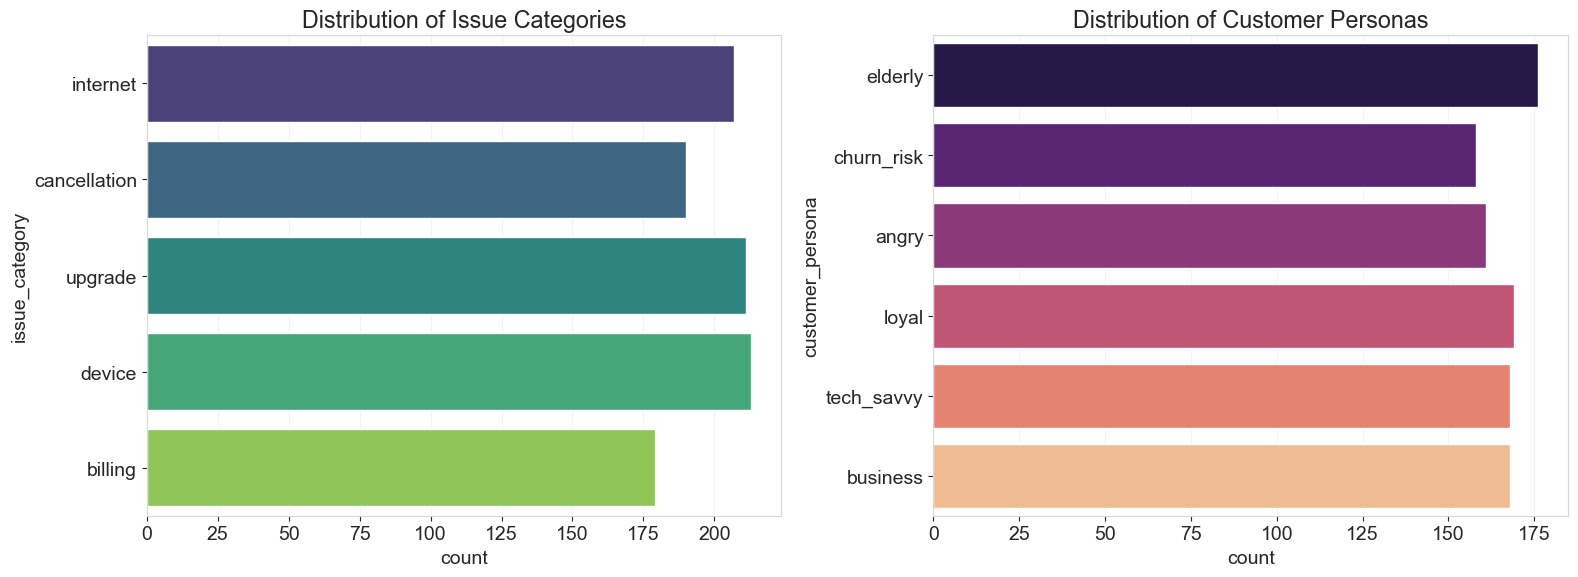

In [9]:
# Check for missing values and data types
print("--- Data Health Check ---")
print(processed_df.info())

# Visualize the distribution of categorical features
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=processed_df, y='issue_category', ax=ax[0], palette='viridis')
ax[0].set_title('Distribution of Issue Categories')

sns.countplot(data=processed_df, y='customer_persona', ax=ax[1], palette='magma')
ax[1].set_title('Distribution of Customer Personas')

plt.tight_layout();
plt.show();

### 2. Efficiency Metrics: Call Duration and Turn Density
Here, we analyze how much "effort" goes into a call. By looking at the distribution of duration_sec and turns_count, we can identify if certain calls are unusually long, which might indicate complex technical issues or agent inefficiency.

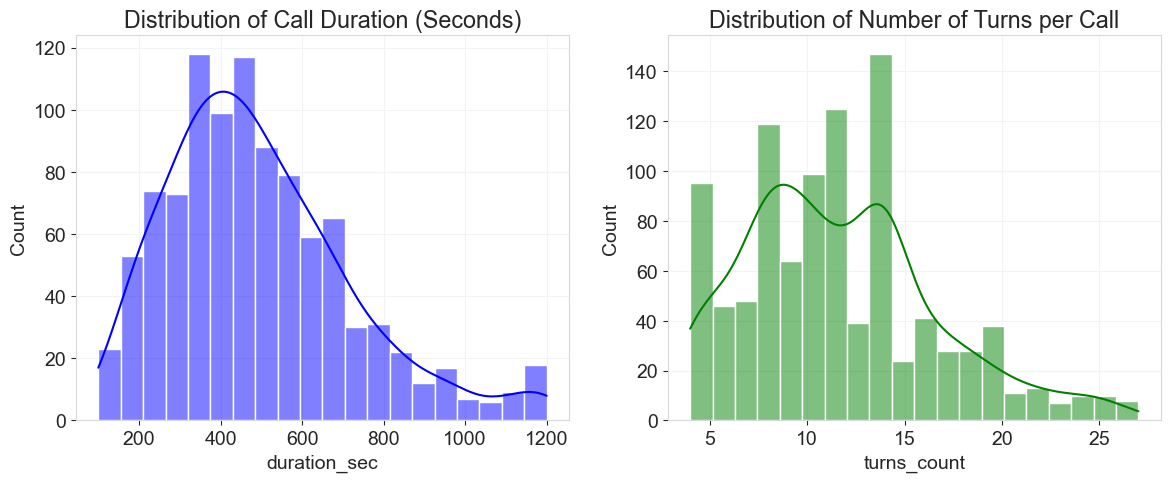

In [10]:
plt.figure(figsize=(14, 5))

# Plot Duration Distribution
plt.subplot(1, 2, 1)
sns.histplot(processed_df['duration_sec'], kde=True, color='blue')
plt.title('Distribution of Call Duration (Seconds)')

# Plot Turn Count Distribution
plt.subplot(1, 2, 2)
sns.histplot(processed_df['turns_count'], kde=True, color='green')
plt.title('Distribution of Number of Turns per Call')

plt.show()

### 3. Behavioral Analysis: The "Talk-to-Listen" Ratio
This is one of our most important engineered features. We are looking for the "sweet spot" in agent communication. A high ratio means the agent is dominating the conversation, while a very low ratio might mean the agent isn't providing enough guidance.

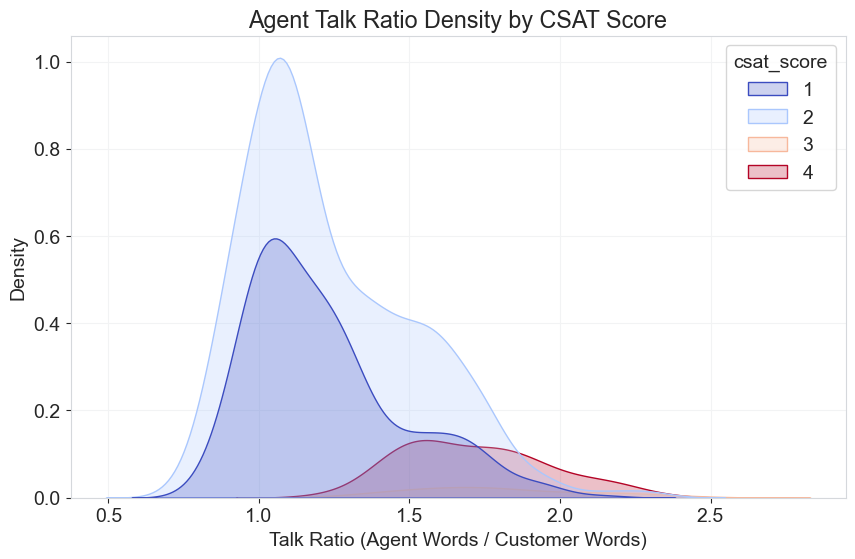

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=processed_df, x='talk_ratio', hue='csat_score', fill=True, palette='coolwarm')
plt.title('Agent Talk Ratio Density by CSAT Score')
plt.xlabel('Talk Ratio (Agent Words / Customer Words)')
plt.ylabel('Density')
plt.show()

## 4. Correlation Matrix: Identifying Key Performance Drivers
We use a heatmap to identify which features have the strongest relationship with our target metrics like csat_score, escalated, and churned. This guides our feature selection for the upcoming clustering and predictive models.

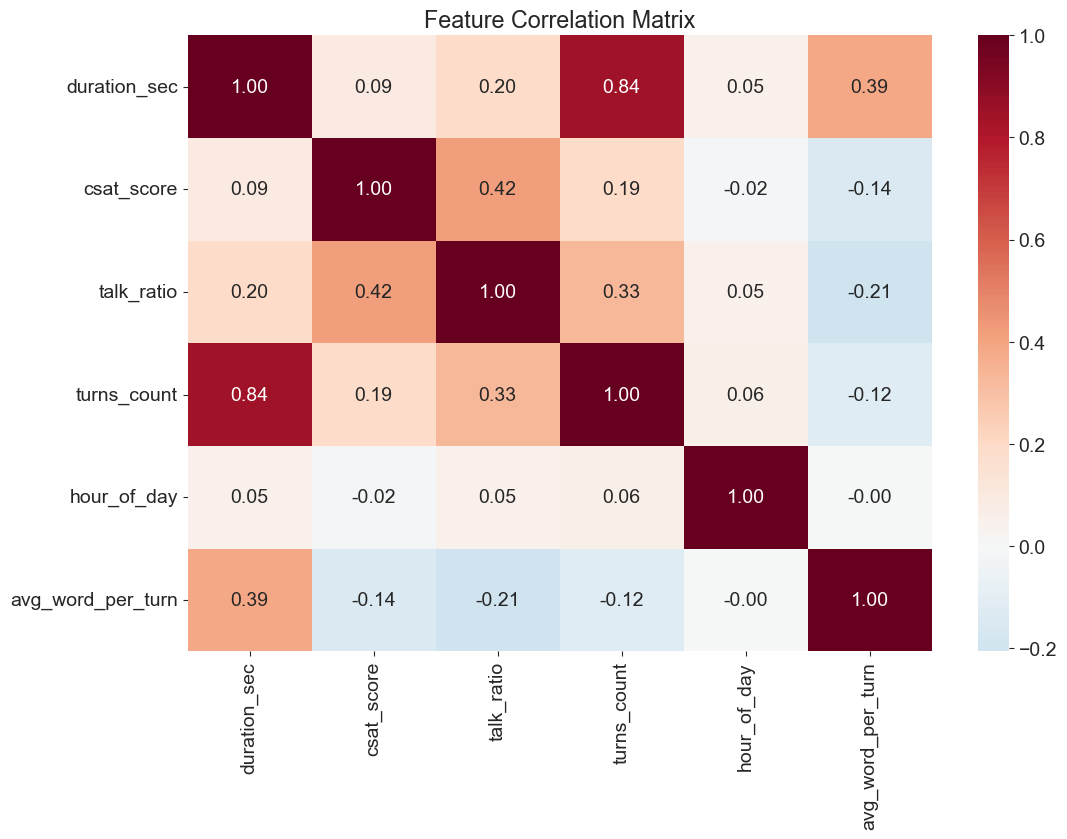

In [12]:
# Select only numerical columns for correlation
numerical_cols = processed_df.select_dtypes(include=['float64', 'int64', 'int32']).columns
corr_matrix = processed_df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

### 5. Deep Dive: Escalation Drivers & Issue Complexity
Now that our style is locked, we look for the "Why" behind call failures. We are specifically looking at which issue_category leads to the highest escalated rates and how duration_sec plays a role in that friction.

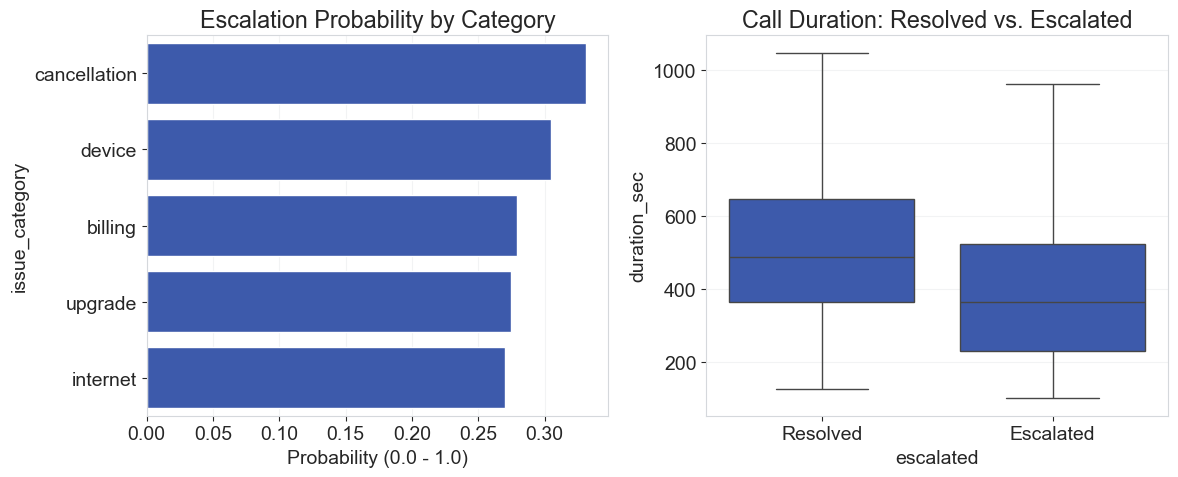

In [13]:
# Calculate escalation rates by issue category
escalation_analysis = processed_df.groupby('issue_category')['escalated'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 5))

# Subplot 1: Escalation Rate by Category
plt.subplot(1, 2, 1)
sns.barplot(data=escalation_analysis, x='escalated', y='issue_category')
plt.title('Escalation Probability by Category')
plt.xlabel('Probability (0.0 - 1.0)')

# Subplot 2: Duration vs Escalation
plt.subplot(1, 2, 2)
sns.boxplot(data=processed_df, x='escalated', y='duration_sec', showfliers=False)
plt.title('Call Duration: Resolved vs. Escalated')
plt.xticks([0, 1], ['Resolved', 'Escalated'])

plt.tight_layout()
plt.show()

### 6. The "Silent Churn" Signal: Persona vs. Sentiment Metrics
This analysis targets the JD's focus on "Production Efficiency." We examine if certain customer_personas are more likely to churn even when their csat_score isn't at the bottom. This helps identify "at-risk" customers that traditional metrics might miss.

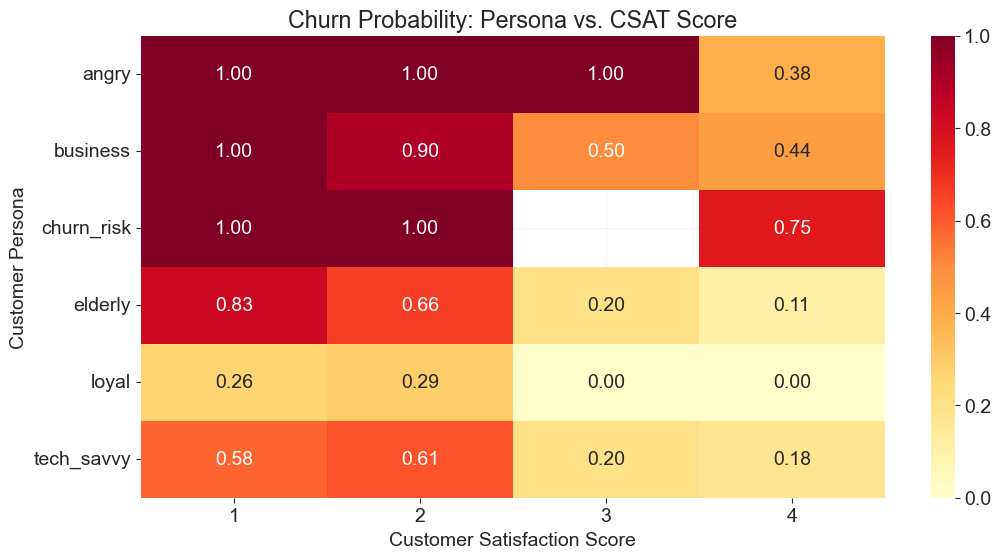

In [14]:
plt.figure(figsize=(12, 6))

# Heatmap of Churn vs Persona vs CSAT
churn_matrix = processed_df.pivot_table(
    index='customer_persona', 
    columns='csat_score', 
    values='churned', 
    aggfunc='mean'
)

sns.heatmap(churn_matrix, annot=True, cmap="YlOrRd", fmt='.2f')
plt.title('Churn Probability: Persona vs. CSAT Score')
plt.xlabel('Customer Satisfaction Score')
plt.ylabel('Customer Persona')

plt.show()

### 7. Research Checkpoint: Exporting the Analytics Baseline
To ensure a consistent state across the pipeline, we export the current dataframe to data/processed/. This baseline includes our engineered behavioral metrics (talk ratio, duration) and will serve as the immutable input for our NLP experiments.

In [15]:
# Create directory if it doesn't exist
processed_dir = os.path.join('..', 'data', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# Save the baseline CSV
base_path = os.path.join(processed_dir, 'analytics_base.csv')
processed_df.to_csv(base_path, index=False)

print(f"Checkpoint 01 Complete: Baseline saved with {processed_df.shape[0]} records.")

Checkpoint 01 Complete: Baseline saved with 1000 records.
